# 인코딩(encoding)과 디코딩(decoding)

- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크

- 인코더는 입력 샘플을 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑하는 여함수

- 예를 들어, 이미지와 오디오 압축 포맷

  - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 때 픽셀 값을 복원하기 위해 디코딩

  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>

# 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크  
  즉, 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑하고,  
  디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

- 원본 입력을 재구성하는 방법으로 학습

- 고전적인 방식은 구조화가 잘된 잠재 공간을 만들지 못하고,  
  압축도 뛰어나지 않음

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>

## Fashion MNIST Dataset

- 코드 참조 : https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

[과제] Fashion MNIST Dataset으로 오토 인코더를 활용하여 이미지 생성을 수행하세요.

# 0429 수업

autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다. 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성합니다. 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련합니다.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [6]:
(x_train, _), (x_test,_) = fashion_mnist.load_data()

In [7]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

print('차원 변경 전:',x_train.shape)

x_train = x_train[..., tf.newaxis] # tf.newaxis로 차원 수 늘리기
x_test = x_test[..., tf.newaxis]

print('차원 변경 후:',x_train.shape) # 차원이 늘어났다!

차원 변경 전: (60000, 28, 28)
차원 변경 후: (60000, 28, 28, 1)


In [8]:
# 이미지에 임의의 노이즈 추가
# 별 건 아니고 각각 이미지 픽셀의 값에 랜덤한 변동을 주어 픽셀 색을 바꿨다고 생각하면 됨.

noise=0.2
x_train_noise = x_train + noise*tf.random.normal(shape=x_train.shape)
x_test_noise = x_test + noise*tf.random.normal(shape=x_test.shape)

# 텐서가 주어지면 값이 clip_value_min과 clip_value_max로 클리핑 된 텐서와 동일한 유형, 모양의 텐서를 반환
x_train_noise = tf.clip_by_value(x_train_noise, clip_value_min=0., clip_value_max=1.)
x_test_noise = tf.clip_by_value(x_test_noise, clip_value_min=0., clip_value_max=1.)

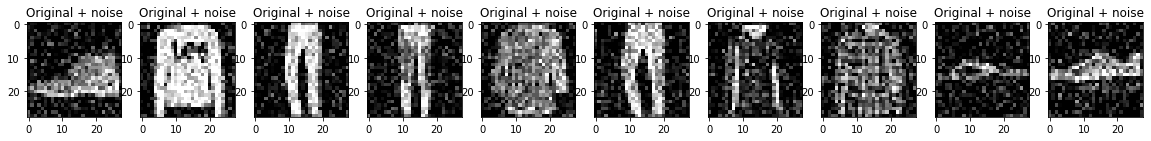

In [9]:
n=10
plt.figure(figsize=(20,2))

for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.title('Original + noise')
  plt.imshow(tf.squeeze(x_test_noise[i]))
  plt.gray()
plt.show()

In [10]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([layers.Input(shape=(28,28,1)),
                                        layers.Conv2D(16,(3,3), activation='relu', padding='same', strides=2),
                                        layers.Conv2D(8,(3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([layers.Conv2DTranspose(8,kernel_size=3, activation='relu', padding='same', strides=2),
                                        layers.Conv2DTranspose(16,kernel_size=3, activation='relu', padding='same', strides=2),
                                        layers.Conv2D(1,kernel_size=(3,3), activation='sigmoid', padding='same')])
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [11]:
autoencoder = Denoise()

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noise, x_train,
                epochs=10, shuffle=True, validation_data=(x_test_noise, x_test))

Epoch 1/10
1875/1875 [==============================] - 52s 27ms/step - loss: 0.0174 - val_loss: 0.0102
Epoch 2/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 4/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 5/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 6/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 8/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 9/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/10
1875/1875 [==============================] - 53s 28m

In [13]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [15]:
encoded_img = autoencoder.encoder(x_test).numpy()
decoded_img = autoencoder.decoder(encoded_img).numpy()

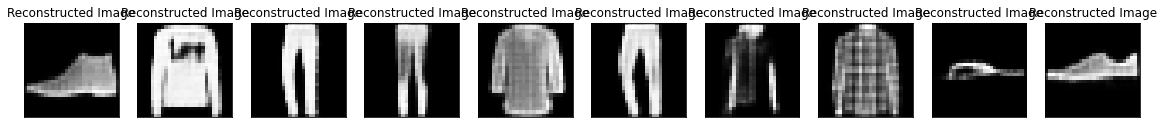

In [18]:
n=10
plt.figure(figsize=(20,4))

for i in range(n):
  # display original + noise
  ax = plt.subplot(1, n, i+1)
  plt.title('Original + noise')
  plt.imshow(tf.squeeze(x_test_noise[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction image
  bx = plt.subplot(2, n, i+n+1)
  plt.title('Reconstructed Image')
  plt.imshow(tf.squeeze(decoded_img[i]))
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)

  plt.gray()
plt.show()

## 개요

이 예에서는 [ECG5000 데이터세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도](https://en.wikipedia.org/wiki/Electrocardiography)가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

In [41]:
# 데이터셋 다운로드

import pandas as pd

df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values # 데이터 프레임을 배열로 바꾼다
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [42]:
print(df.shape,
      raw_data.shape, raw_data.dtype)

(4998, 141) (4998, 141) float64


In [43]:
df.iloc[:,-1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [44]:
label = raw_data[:,-1]
data = raw_data[:,0:-1]

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=21)

In [45]:
# 데이터를 [0,1]로 정규화(Min-Max scale)

min_value = tf.reduce_min(train_data)
max_value = tf.reduce_max(train_data)

train_data = (train_data - min_value) / (max_value - min_value)
test_data = (test_data - min_value) / (max_value - min_value) # 테스트 데이터에는 자체 값을 연산에 사용하면 안 되니까!

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

In [46]:
train_data.shape

TensorShape([3998, 140])

이 데이터셋에서 1로 레이블 된 정상 리듬만 사용하여 autoencoder를 훈련하자.

In [47]:
train_label = train_label.astype(bool)
test_label = test_label.astype(bool)

normal_train_data = train_data[train_label]
normal_test_data = test_data[test_label]

anomalous_train = train_data[~train_label]
anomalous_test = test_data[~test_label]

In [48]:
normal_train_data.shape

TensorShape([2359, 140])

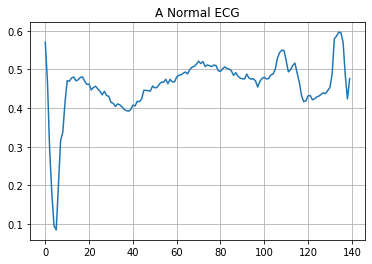

In [50]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

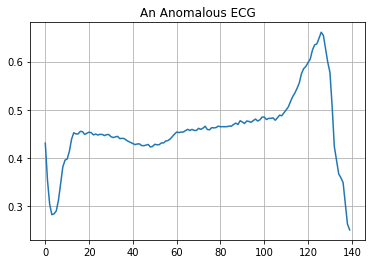

In [51]:
plt.grid()
plt.plot(np.arange(140), anomalous_train[0])
plt.title('An Anomalous ECG')
plt.show()

In [52]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')])
    
    self.decoder = tf.keras.Sequential([layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [53]:
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(normal_train_data, normal_test_data,
                          epochs=20, batch_size=512, shuffle=True, validation_data=(test_data, test_data))

ValueError: ignored